***Image setup***

In [35]:
# Standard image setup
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

***Import library***

In [36]:
# Import basic library to processing data
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns 
import yfinance as yf

plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 500 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
# Import statics model using for running model 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

***Input data***

In [38]:
# Import data from yahoo.finance
df_mana = yf.download('MANA-USD', 
                       start='2015-01-01', 
                       end='2021-12-10',
                       progress=False)

***Data Processing***

In [39]:
# Select "Adj Close" attribute for calculation.
df_mana = pd.DataFrame(df_mana['Adj Close'])

In [40]:
# Check number of missing data in the datasets
print(f'The number of missing data:\n{df_mana.isnull().sum()}')

The number of missing data:
Adj Close    0
dtype: int64


In [41]:
# Resample daily data into weekly data
df_mana = df_mana.resample('W-Fri').ffill() 

In [42]:
df_mana.tail()

,Adj Close
Date,
2021-11-12,3.297853
2021-11-19,4.290613
2021-11-26,4.639659
2021-12-03,3.908493
2021-12-10,3.464618


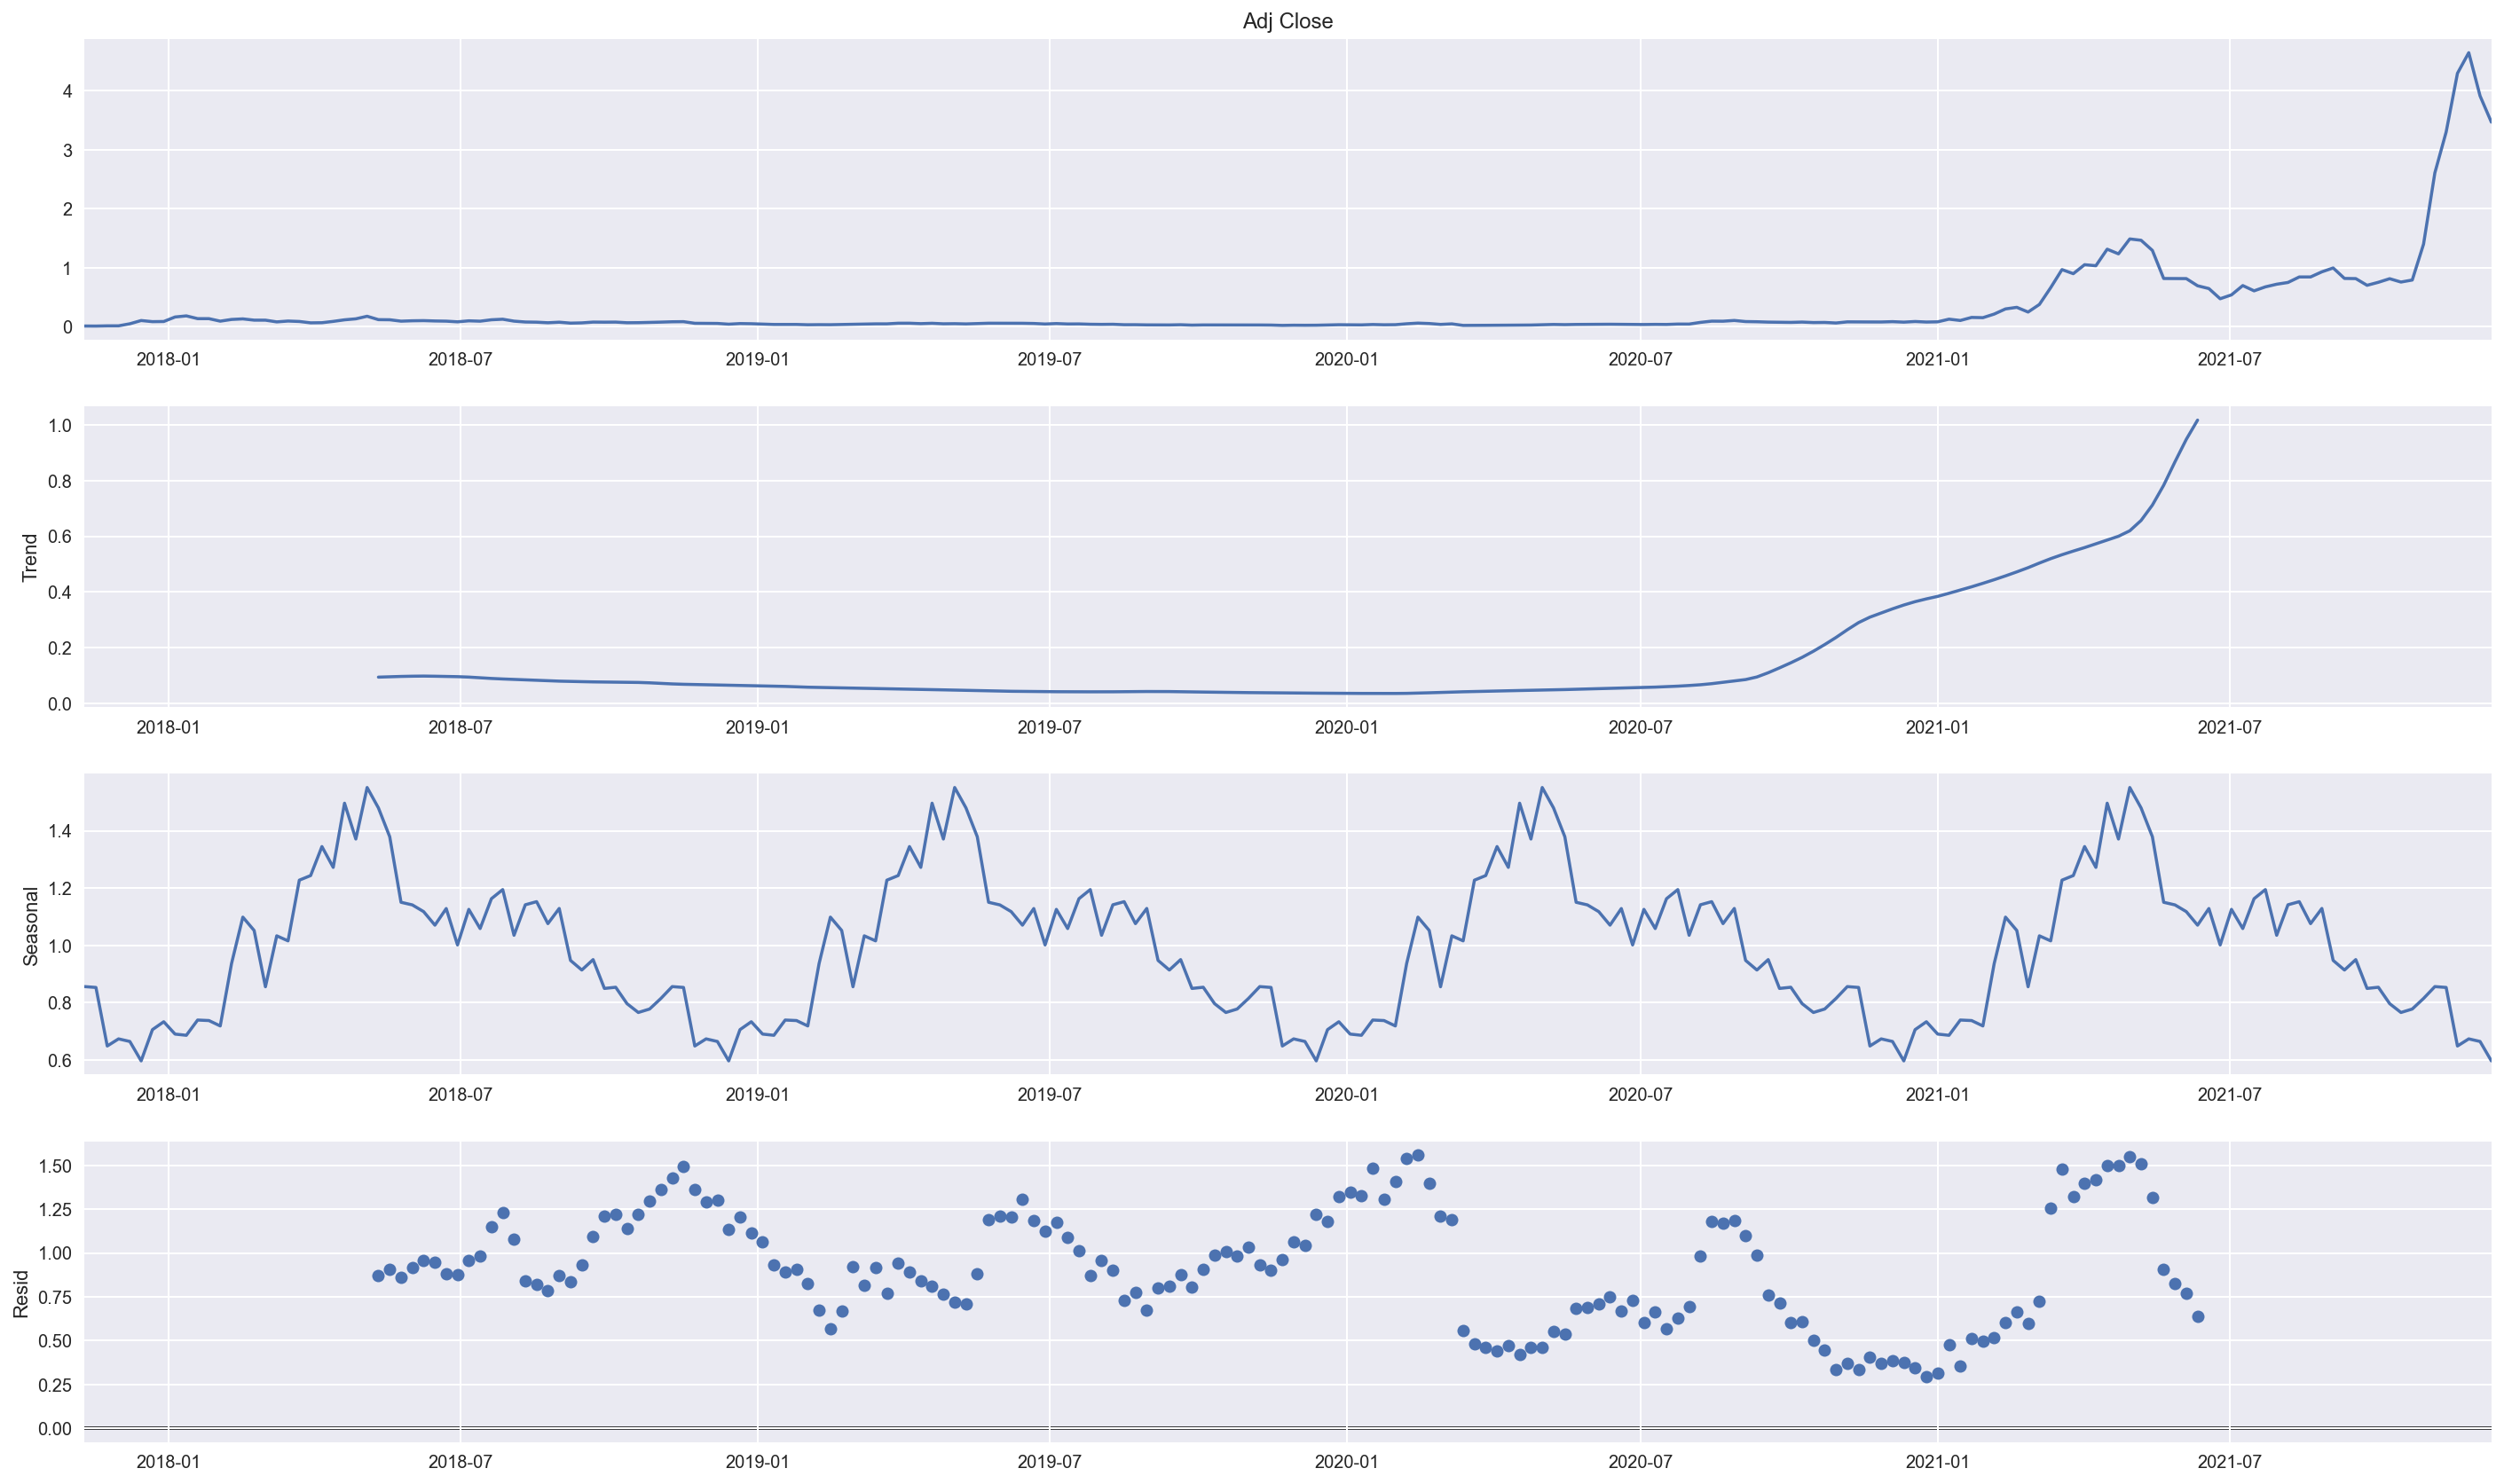

In [43]:
# Update size and font for image
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 20})

# Plot the data decay
decompose_results = seasonal_decompose(df_mana['Adj Close'],model='multiplicative')
decompose_results.plot()

plt.show()


MANA price have clearly trend and seasonal movement, so MANA price is not stationary

***ADF test and KPSS test***

In [44]:
# Function ADF test
def adf_test(x):

    stats_index = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']

    test_adf = adfuller(x, autolag='AIC')
    results = pd.Series(test_adf[0:4], index = stats_index)

    for key, value in test_adf[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [45]:
# Function KPSS test
def kpss_test(x):

    stats_index = ['Test Statistic', 'p-value', '# of Lags']

    test_kpss = kpss(x)
    results = pd.Series(test_kpss[0:3], index = stats_index)

    for key, value in test_kpss[3].items():
        results[f'Critical Value ({key})'] = value

    return results

*Test with Adj Close*

In [46]:
# Test ADF with the adjust close price.
print('ADF test result of the adjust close price:')
adf_test(df_mana)

ADF test result of the adjust close price:


Test Statistic              1.345641
p-value                     0.996853
# of Lags Used             14.000000
# of Observations Used    199.000000
Critical Value (1%)        -3.463645
Critical Value (5%)        -2.876176
Critical Value (10%)       -2.574572
dtype: float64

In [47]:
# Test KPSS with the adjust close price.
print('KPSS test result of the adjust close price:')
kpss_test(df_mana)

KPSS test result of the adjust close price:


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic            0.759257
p-value                   0.010000
# of Lags                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

*Test with the first difference*

In [48]:
# Create a first difference column.
df_mana['diff'] = df_mana['Adj Close'].diff()
df_mana.dropna(inplace=True)

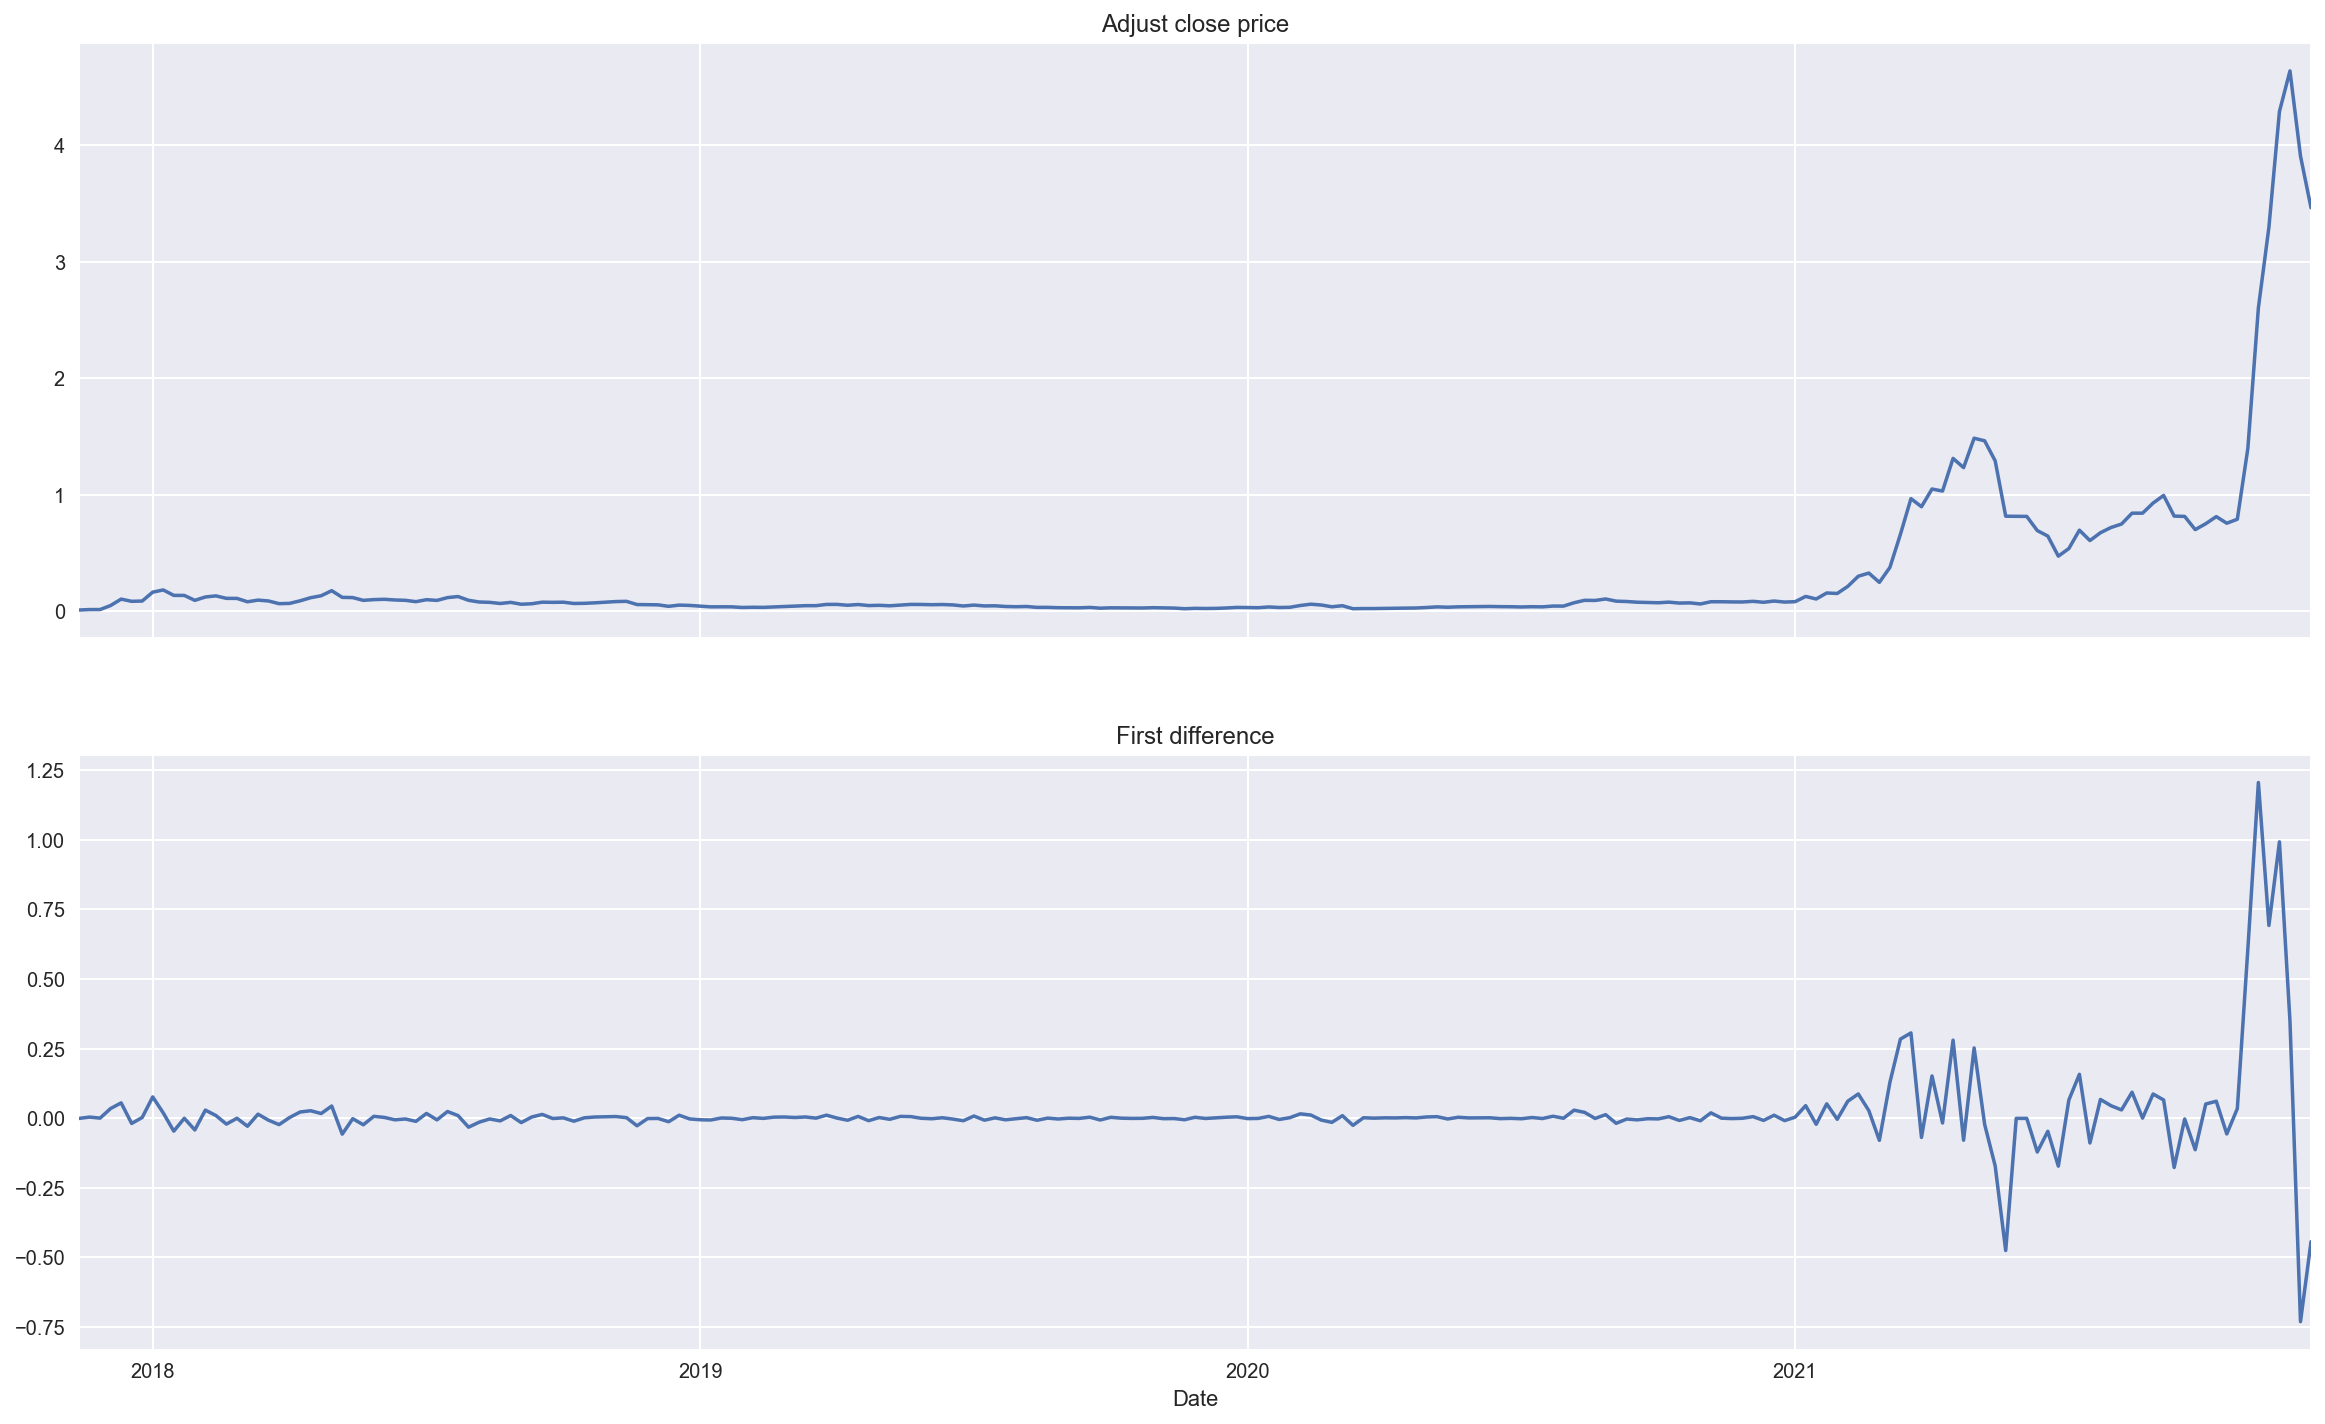

In [49]:
# Update size and font for image
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 20})

# Ploting two adjust close price and first difference chart
fig, ax = plt.subplots(2, sharex = True)
df_mana['Adj Close'].plot(ax = ax[0], title = 'Adjust close price')
df_mana['diff'].plot(ax = ax[1], title = 'First difference')

plt.show()

In [50]:
# Test ADF with the first-order difference.
print('ADF test result of the first-order difference:')
adf_test(df_mana['diff'])

# Test KPSS with the first-order difference.
print('KPSS test result of the first-order difference:')
kpss_test(df_mana['diff'])


ADF test result of the first-order difference:
KPSS test result of the first-order difference:


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic            0.346925
p-value                   0.100000
# of Lags                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

***Autocorrelation test***


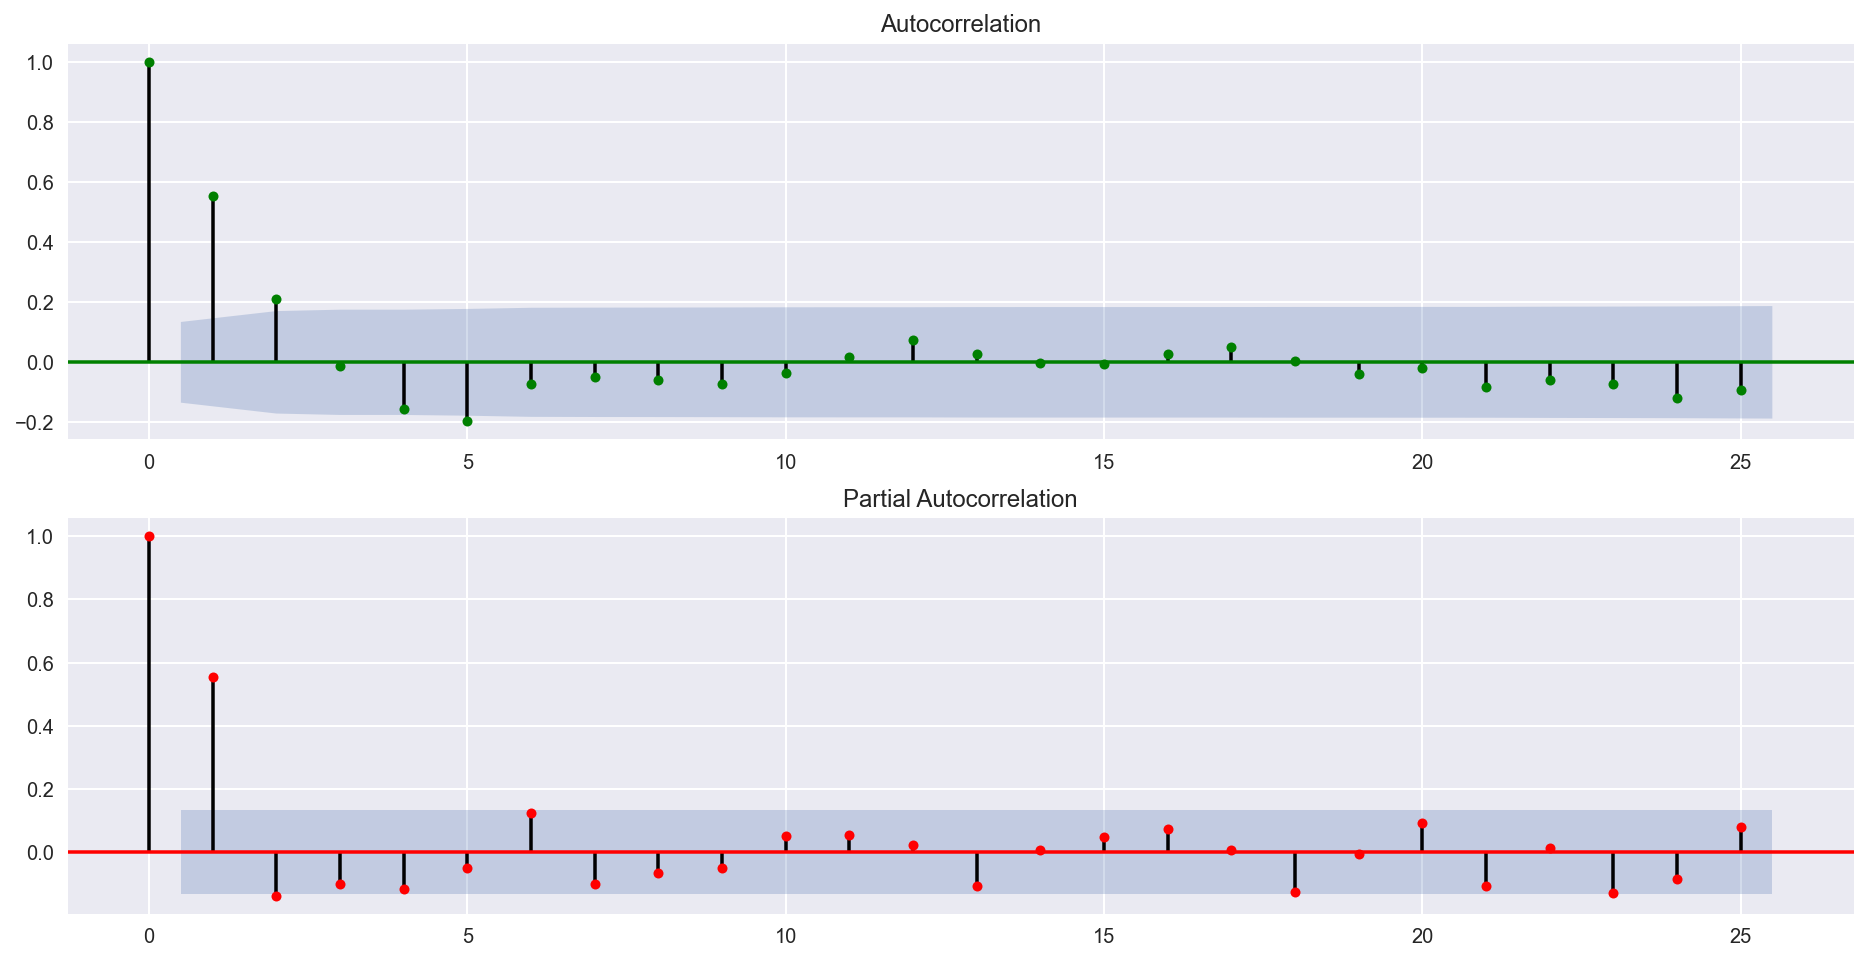

In [51]:
# Specify parameters
n_lags = 25
significance_level = 0.05

# Update size and font for image
%matplotlib inline
plt.rcParams['figure.figsize'] = [22, 18]
plt.rcParams.update({'font.size': 20}) 

# Draw plot
fig, ax = plt.subplots(2, figsize=(16, 8))

# Plot ACF
plot_acf(df_mana['diff'], ax = ax[0], lags = n_lags, 
         alpha = significance_level, c= 'green')

# Plot PACF
plot_pacf(df_mana['diff'], ax = ax[1], lags = n_lags, 
          alpha = significance_level,c= 'red')

plt.show()

***ARMIA model results***

In [52]:
arima = sm.tsa.arima.ARIMA(df_mana['Adj Close'], order = (2, 1, 3)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  213
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 152.455
Date:                Sun, 23 Jan 2022   AIC                           -292.911
Time:                        23:01:40   BIC                           -272.771
Sample:                    11-17-2017   HQIC                          -284.771
                         - 12-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8486      0.068     12.468      0.000       0.715       0.982
ar.L2         -0.7031      0.048    -14.601      0.000      -0.798      -0.609
ma.L1         -0.2736      0.096     -2.860      0.0

***White residual test***

In [53]:
def arima_diagnostics(resids, n_lags=25):
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    # Calculate resids
    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # Distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    # Plot distribution
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

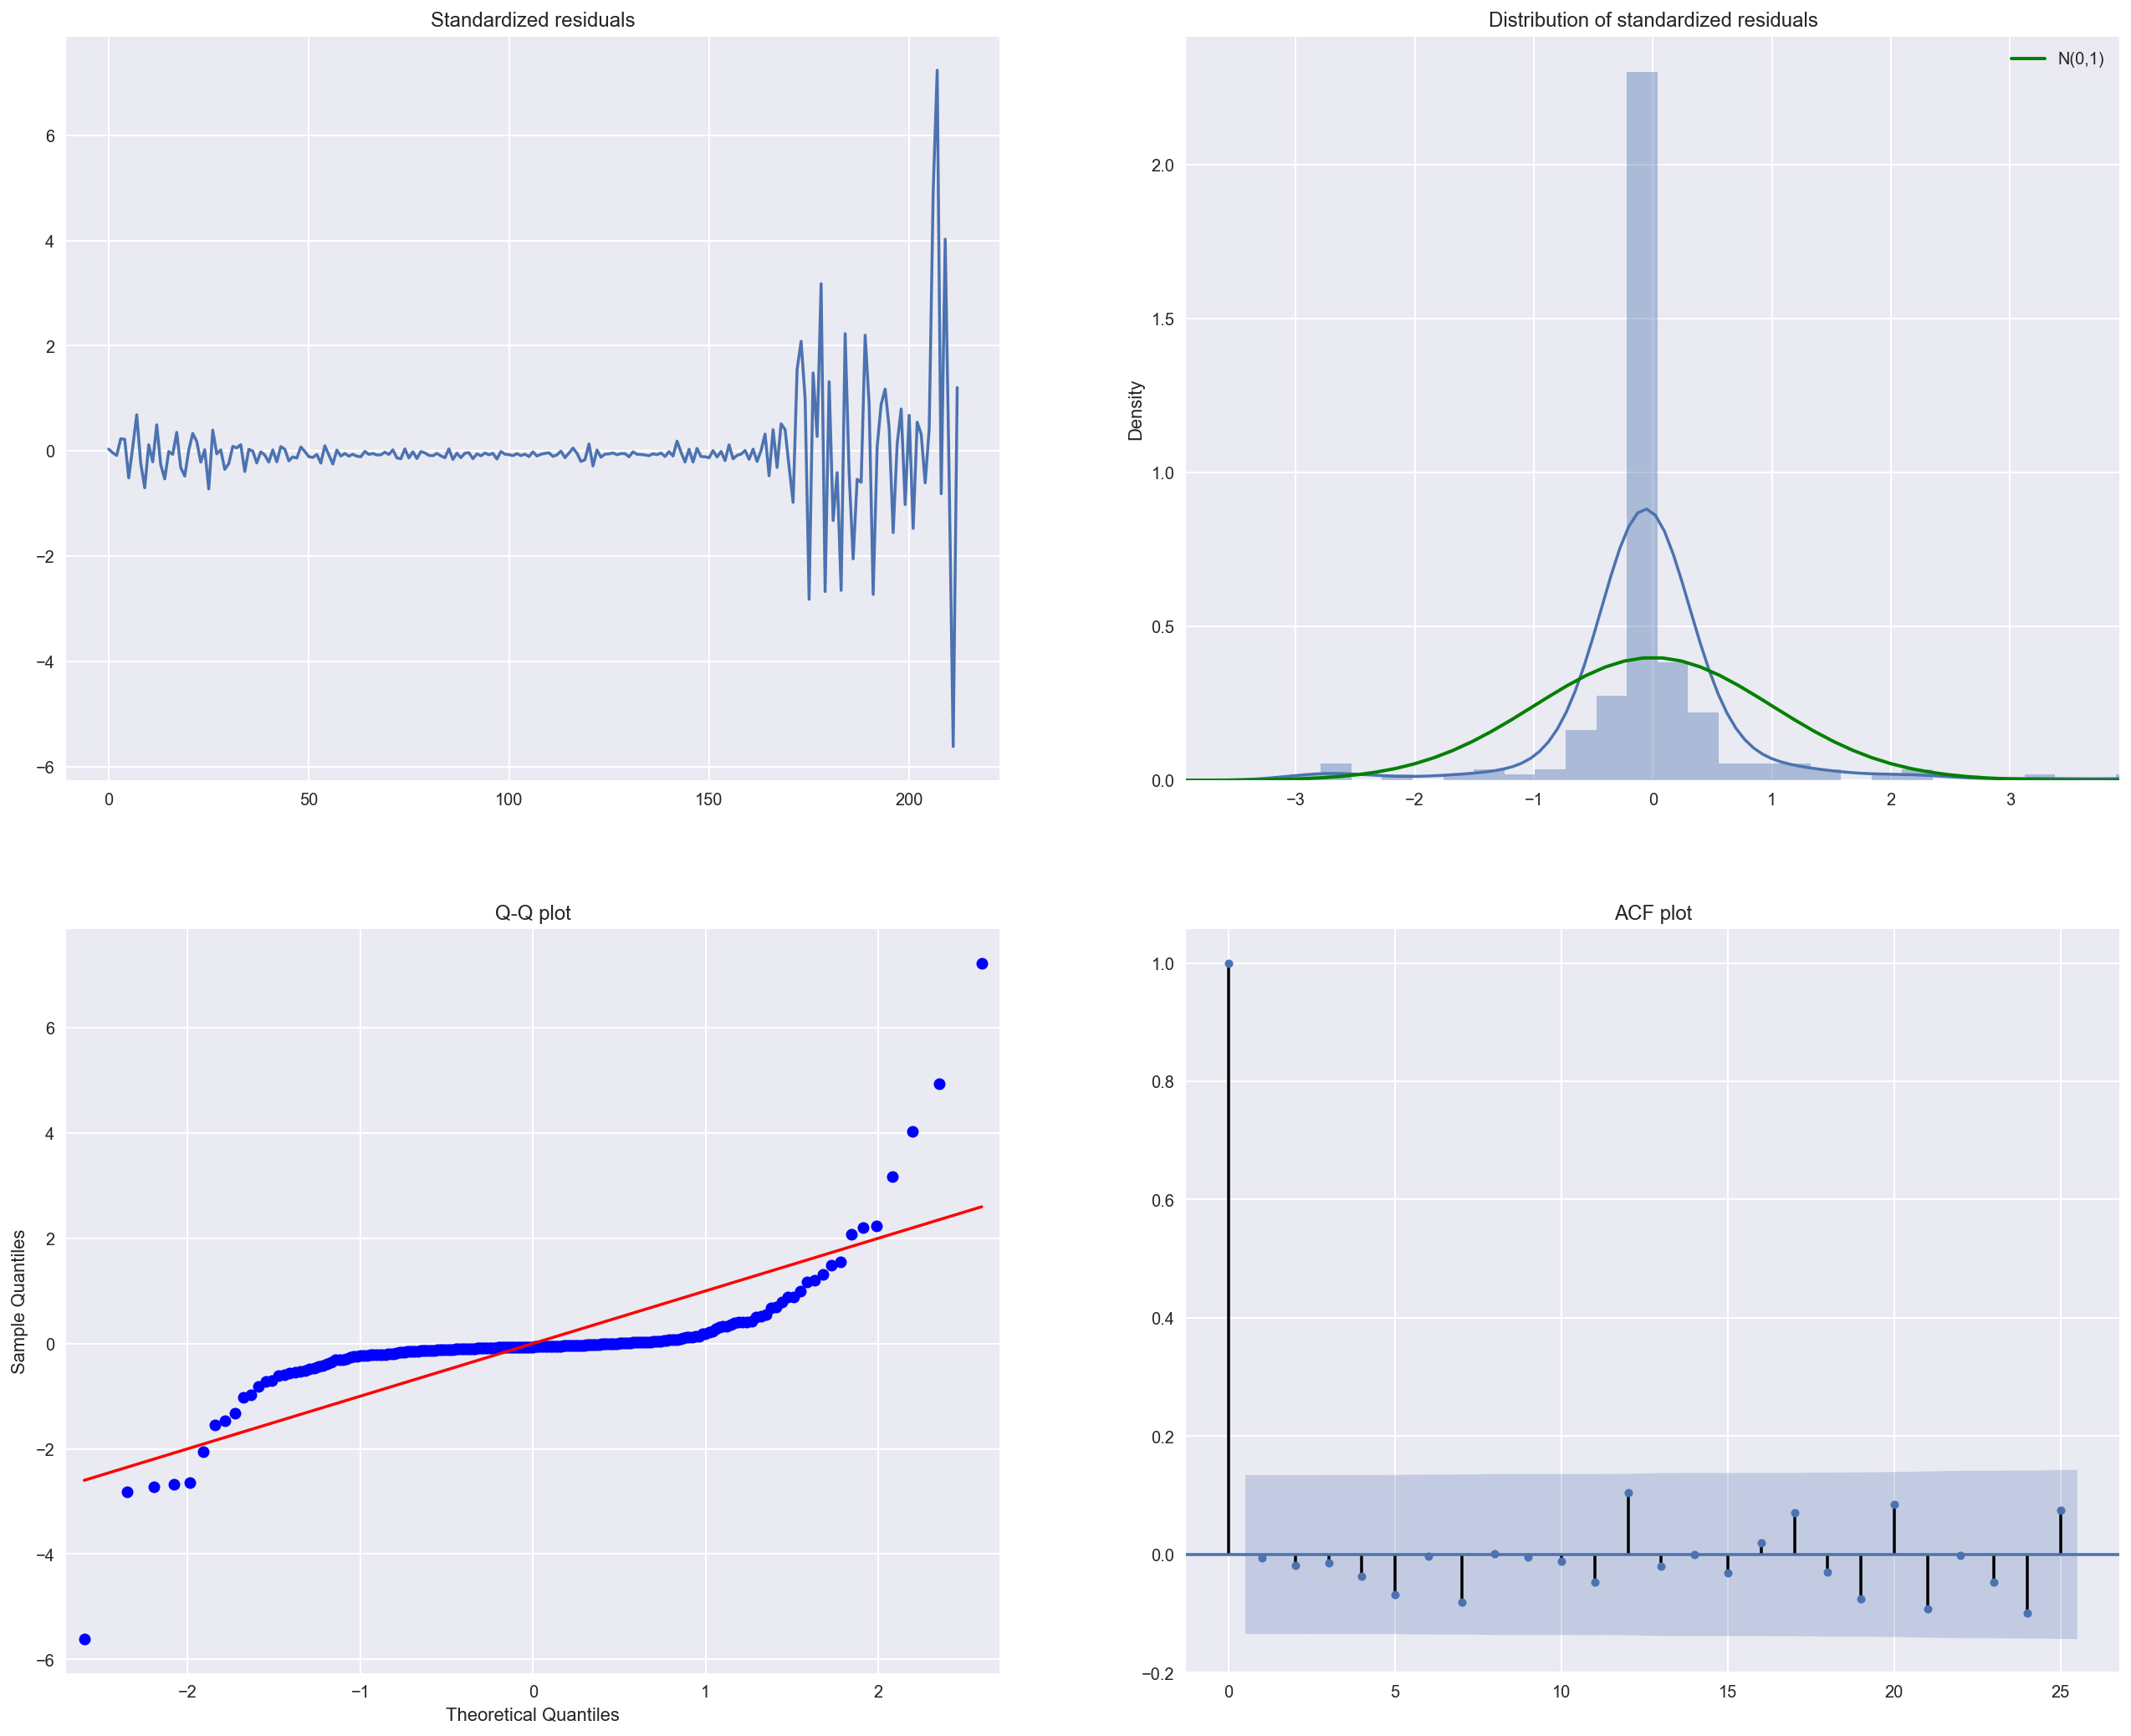

In [54]:
# Run residual testing function
arima_diagnostics(arima.resid, 25)
plt.show();

***Forcast future value***

In [55]:
# import data used for forcasting

data_forecast = yf.download('MANA-USD', 
                       start='2021-12-17', 
                       end='2022-01-20',
                       progress=False)

data_forecast = data_forecast['Adj Close'].resample('W-Fri').ffill() 

In [56]:
data_forecast

Date
2021-12-17    3.072275
2021-12-24    3.505177
2021-12-31    3.270671
2022-01-07    3.051883
2022-01-14    2.955072
2022-01-21    2.735672
Freq: W-FRI, Name: Adj Close, dtype: float64

In [57]:
# Forecast length
n_forecasts = len(data_forecast)

# ARIMA forecast restults
arima_pred = arima.forecast(n_forecasts,freq='W')

# Concatenate forecast data
arima_pred = pd.DataFrame(arima_pred)
arima_pred.columns = ['Predict']

In [59]:
volatility = pd.DataFrame({'Real price': list(data_forecast),
                           'Prediction price': list(arima_pred.Predict)},
                           index= data_forecast.index)

In [60]:
volatility

,Real price,Prediction price
Date,,
2021-12-17,3.072275,3.100168
2021-12-24,3.505177,3.021332
2021-12-31,3.270671,3.252766
2022-01-07,3.051883,3.504594
2022-01-14,2.955072,3.555564
2022-01-21,2.735672,3.421748


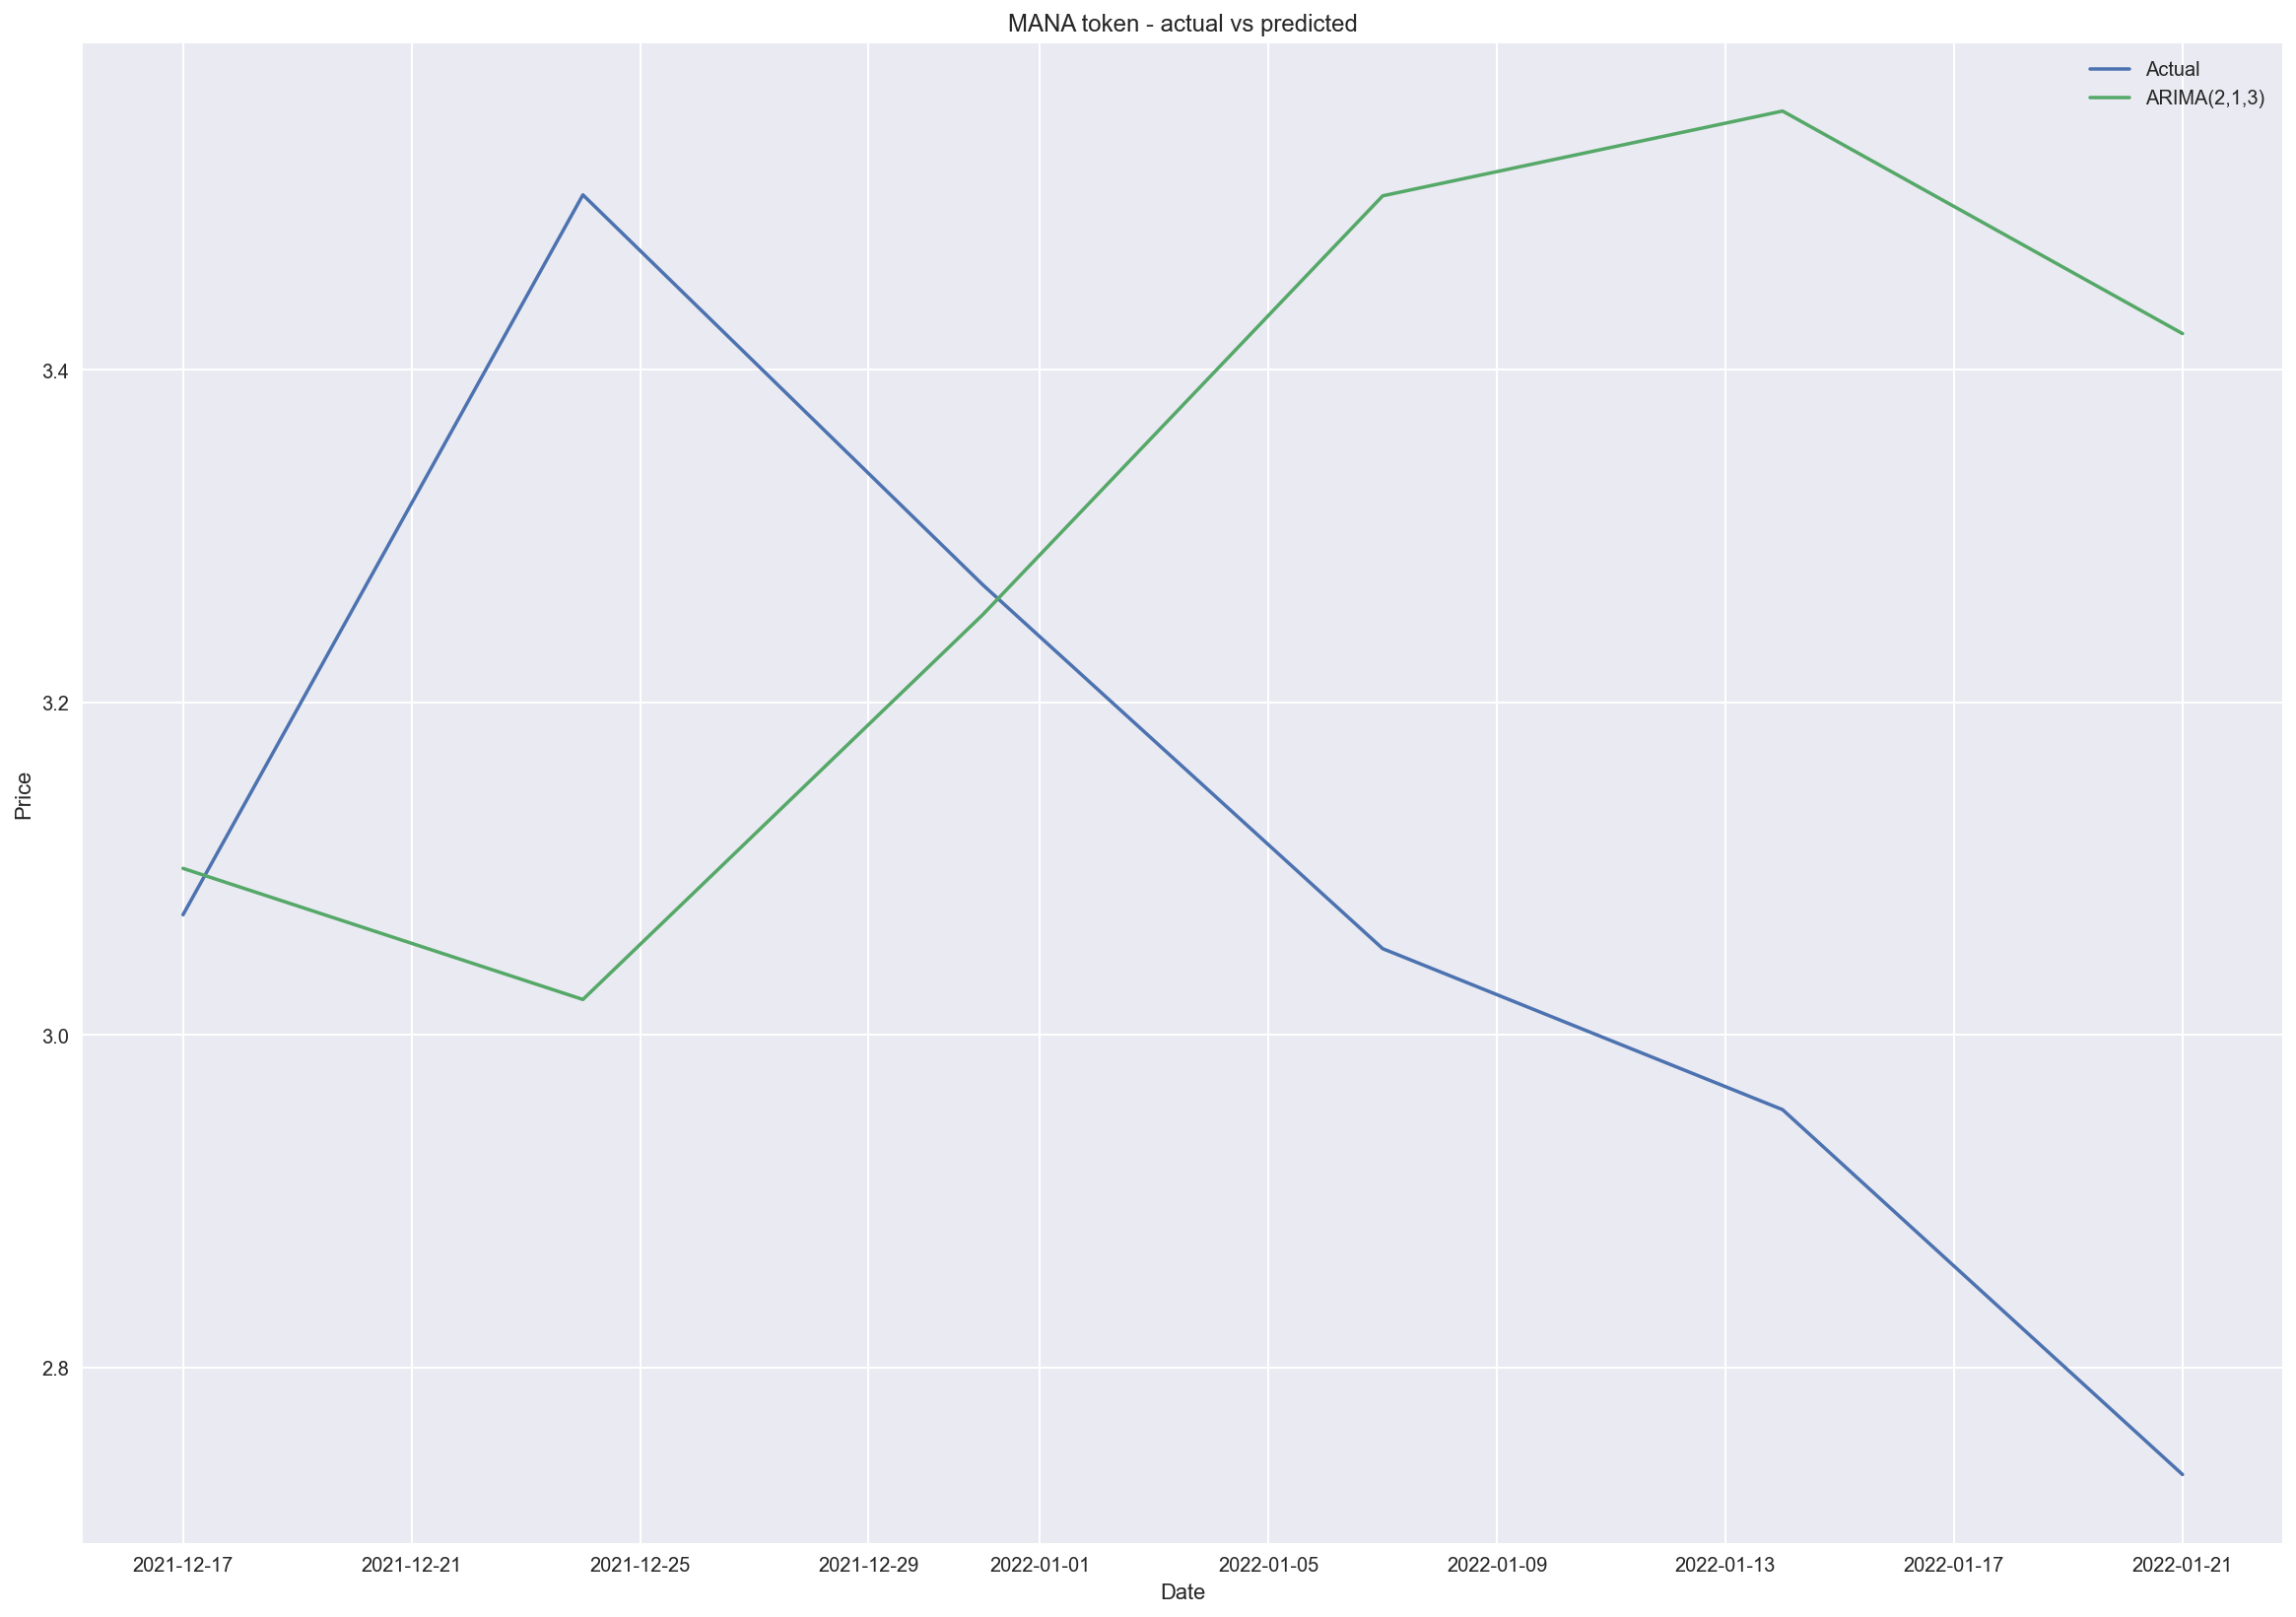

In [61]:
# Plot forecast results
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 14]
plt.rcParams.update({'font.size': 20}) 

fig, ax = plt.subplots(1)
ax = sns.lineplot(data = data_forecast, label = 'Actual')
ax.plot(arima_pred.Predict, label = 'ARIMA(2,1,3)')
ax.set(title="MANA token - actual vs predicted", xlabel = 'Date', ylabel = 'Price')
       
plt.legend()

plt.show()

***The volatility between actual and prediction price***

In [62]:
rmse = np.sqrt(mean_squared_error(data_forecast, arima_pred.Predict))
mae = mean_absolute_error(data_forecast, arima_pred.Predict)
mape = (mean_absolute_percentage_error(data_forecast, arima_pred.Predict))*100

In [63]:
print(f'RMSE = {round(rmse,2)}')
print(f'MAE  = {round(mae,2)}')
print(f'MAPE = {round(mape,2)}%')


RMSE = 0.46
MAE  = 0.38
MAPE = 12.58%
